# Rockley Bio-Sensor Selection Codesign Playground

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Mount Google Drive and configure PYTHONPATH variable

**Before running:** Find the `optimized_bio_sensor` folder in Drive and use the `Add shortcut to Drive` option to add it to `MyDrive`

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1EaHvULJYewcfEpQ7wlYgmG1eRbVcahUv/optimized_bio_sensor/RockleyCodesign


# Load Data

In [ ]:
df = pd.read_parquet("../data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X = data[:, :-1]
Y = data[:, -1]

print(np.shape(X), np.shape(Y))

(160000, 197) (160000,)


## Distribution stuff

Seeing a pretty even distribution on Y. Range from 0 to 200

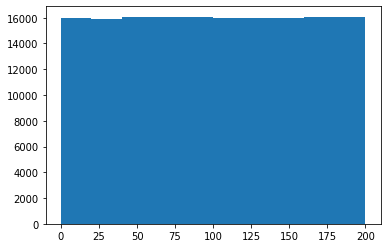

In [ ]:
plt.hist(Y, bins=10)
plt.show()


In [ ]:
df.describe().round(2)

,Laser 1,Laser 2,Laser 3,Laser 4,Laser 5,Laser 6,Laser 7,Laser 8,Laser 9,Laser 10,...,Laser 189,Laser 190,Laser 191,Laser 192,Laser 193,Laser 194,Laser 195,Laser 196,Laser 197,eEthanol
count,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,...,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00,160000.00
mean,1.35,1.50,1.65,1.80,1.92,2.01,2.07,2.12,2.15,2.17,...,2.78,2.81,2.85,2.88,2.91,2.92,2.93,2.95,2.97,100.08
std,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.10,0.10,0.11,...,0.19,0.19,0.20,0.21,0.21,0.21,0.21,0.22,0.22,57.74
min,1.24,1.35,1.47,1.56,1.64,1.70,1.75,1.78,1.80,1.81,...,2.17,2.19,2.20,2.22,2.23,2.24,2.24,2.25,2.26,0.00
25%,1.33,1.47,1.61,1.75,1.86,1.94,2.00,2.05,2.08,2.10,...,2.65,2.68,2.71,2.74,2.76,2.77,2.78,2.80,2.82,50.12
50%,1.35,1.50,1.65,1.80,1.91,2.00,2.07,2.11,2.15,2.17,...,2.77,2.80,2.84,2.88,2.90,2.91,2.92,2.94,2.96,100.02
75%,1.38,1.53,1.69,1.85,1.97,2.06,2.13,2.18,2.22,2.24,...,2.90,2.94,2.98,3.02,3.04,3.05,3.07,3.09,3.12,150.12
max,1.52,1.72,1.93,2.14,2.31,2.44,2.54,2.61,2.66,2.68,...,3.70,3.76,3.83,3.90,3.94,3.95,3.98,4.02,4.06,200.00


# Trying out models with Sklearn

In [ ]:
# Utility functions

# Normalize Data
def normalize(X_train, X_test, Y_train):
  X_mean = np.mean(X_train, axis=0)
  X_std = np.std(X_train, axis=0)

  X_train_norm = np.array(X_train)
  X_test_norm = np.array(X_test)
  for i in range(len(X_mean)):
    X_train_norm[:, i] = (X_train[:, i] - X_mean[i]) / X_std[i]
    X_test_norm[:, i] = (X_test[:, i] - X_mean[i]) / X_std[i]

  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  Y_train_norm = (Y_train - Y_mean) / Y_std

  return X_train_norm, X_test_norm, Y_train_norm

def normalize_one(X_train):
  X_mean = np.mean(X_train, axis=0)
  X_std = np.std(X_train, axis=0)

  X_train_norm = np.array(X_train)
  for i in range(len(X_mean)):
    X_train_norm[:, i] = (X_train[:, i] - X_mean[i]) / X_std[i]

  return X_train_norm

def denormalize(Y_train, Y_test):
  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  return Y_test * Y_std + Y_mean

# Plot predicted vs actual graph
def plot_pred_v_actual(Y_pred, Y_actual):
  plt.scatter(Y_actual, Y_pred, s=0.1, color='blue')

  xs = np.linspace(1, 200)
  plt.plot(xs, xs, color='red')

  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title("Predicted vs. Actual Graph")
  plt.show()

# Gives difference in % so 2 is 2% difference
def calc_percent_diff(Y_pred, Y_actual):
  percent_errors = []
  for i in range(len(Y_pred)):
    percent_errors.append(abs((Y_pred[i] - Y_actual[i]) / Y_actual[i]))
  return np.mean(percent_errors) * 100


In [ ]:
# Training functions

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Train with cross-validation
def train_with_CV(X, Y, model, metric, folds=5, norm=False, graph=True, **kwargs):
  metrics = []
  kf = KFold(n_splits=folds)
  for train, test in kf.split(X):
    x_train, y_train = X[train], Y[train]
    x_test, Y_test = X[test], Y[test]
    if norm:
      X_train, X_test, Y_train = normalize(x_train, x_test, y_train)
    else:
      X_train, X_test, Y_train = x_train, x_test, y_train

    reg = model(**kwargs)
    reg.fit(X_train, Y_train)

    Y_pred = reg.predict(X_test)
    if norm:
      Y_pred = denormalize(y_train, Y_pred)
    m = metric(Y_test, Y_pred)
    metrics.append(m)
  # Take last fold and graph its result on test split and last seen regression
  if graph:
    plot_pred_v_actual(Y_pred, Y_test)
  return np.mean(metrics), reg

# Train just by splitting up the data into train/test
def train_with_split(X, Y, model, metric, split_size=0.2, norm=False, graph=True, **kwargs):
  x_train_split, x_test_split, y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.2)
  if norm:
    X_train_split, X_test_split, Y_train_split = normalize(x_train_split, x_test_split, y_train_split)
  else:
    X_train_split, X_test_split, Y_train_split = x_train_split, x_test_split, y_train_split

  reg = model(**kwargs)
  reg.fit(X_train_split, Y_train_split)

  Y_pred = reg.predict(X_test_split)
  if norm:
    Y_pred = denormalize(y_train_split, Y_pred)
  if graph:
    plot_pred_v_actual(Y_pred, Y_test_split)
  return metric(Y_test_split, Y_pred), reg

## Linear Regressions

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e+08, tolerance: 4.259e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e+08, tolerance: 4.275e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

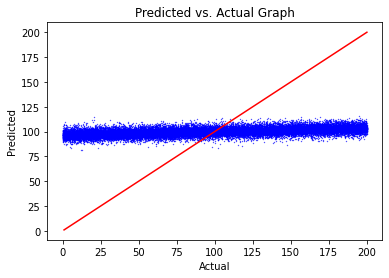

48.30186665058136


In [ ]:
# Normal
import sklearn.linear_model
res, mod = train_with_CV(X, Y, sklearn.linear_model.Lasso, calc_percent_diff, norm=False, alpha=0.01)
print(res)

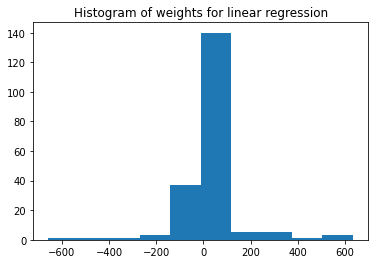

In [ ]:
plt.hist(mod.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()

# Create normalized data set

In [ ]:
train_data = pd.read_parquet("../data/train_regression.parquet")
test_data = pd.read_parquet("../data/test_regression.parquet")
train = train_data.to_numpy(dtype=np.float64)
test = test_data.to_numpy(dtype=np.float64)

means = np.mean(train, axis=0)
stds = np.std(train, axis=0)

train_norm = np.array(train)
test_norm = np.array(test)
for i in range(len(means) - 1):
  train_norm[:, i] = (train[:, i] - means[i]) / stds[i]
  test_norm[:, i] = (test[:, i] - means[i]) / stds[i]

np.save("../data/train_data_normalized.npy", train_norm)
np.save("../data/test_data_normalized.npy", test_norm)


# PyTorch Stuff

In [5]:
data = np.load("../data/train_data_normalized.npy")

big_lasers = range(197)
input_size = len(big_lasers)
X64n = data[:, big_lasers]
Y64 = data[:, -1]

train_size = int(0.8 * len(X64n))
X64n_train, Y64_train = X64n[:train_size], Y64[:train_size]
X64n_test, Y64_test = X64n[train_size:], Y64[train_size:]

X32n_train = np.array(X64n_train, dtype=np.float32)
X32n_test = np.array(X64n_test, dtype=np.float32)
Y32_train = np.array(Y64_train, dtype=np.float32)

X_torch = np.reshape(X32n_train, (-1, input_size))

# Y = np.ones((len(X), 1), dtype=np.float32)
Y_torch = np.reshape(Y32_train, (-1, 1))

In [6]:
import sklearn.linear_model

mod = sklearn.linear_model.LinearRegression()
mod.fit(X_torch, Y32_train)

calc_percent_diff(mod.predict(X_torch), Y32_train)

NameError: ignored

In [ ]:
np.save("../data/actual_weights.npy", mod.coef_)

In [7]:
import torch.nn as nn
import torch

class LinearRegression(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.layer = nn.Linear(input_size, 1)
        # self.layer.weight.data[...] = torch.Tensor(mod.coef_ + np.random.rand(input_size) * 200)
        # self.layer.weight.data[...] = torch.Tensor(np.random.normal(0, 500, input_size))
        # self.layer.bias.data[...] = torch.Tensor([mod.intercept_])
        # print(self.layer.weight.data[0, 0])

    def forward(self, measurements_selected):
        out = self.layer(measurements_selected)
        return out

epoch 0, loss 13350.0322265625
epoch 2500, loss 2830.718505859375
epoch 5000, loss 2403.046630859375
epoch 7500, loss 2093.106689453125
epoch 10000, loss 1842.3924560546875
epoch 12500, loss 1630.931640625
epoch 15000, loss 1685.9720458984375
epoch 17500, loss 1291.8162841796875
epoch 20000, loss 1155.8870849609375
epoch 22500, loss 1036.5596923828125
epoch 25000, loss 964.990966796875
epoch 27500, loss 839.4180297851562
epoch 30000, loss 758.0253295898438
epoch 32500, loss 686.2365112304688
epoch 35000, loss 622.7376098632812
epoch 37500, loss 570.7085571289062
epoch 40000, loss 516.5659790039062
epoch 42500, loss 4949.90478515625
epoch 45000, loss 432.7629699707031
epoch 47500, loss 3058.758056640625


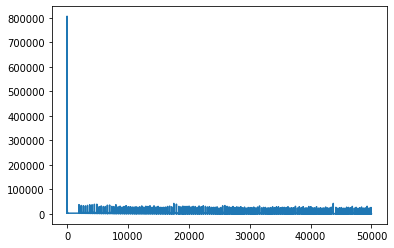

In [11]:
model = LinearRegression(input_size)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=5)

from torch.autograd import Variable

weights = []
losses = []
for epoch in range(50000):
    weights.append(model.layer.weight.data[0, 80] + 0)
    # Converting inputs and labels to Variable
    inputs = Variable(torch.from_numpy(X_torch))
    labels = Variable(torch.from_numpy(Y_torch))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
    if epoch % 2500 == 0:
      print('epoch {}, loss {}'.format(epoch, loss.item()))
    losses.append(loss.item())

plt.plot(losses)
plt.show()

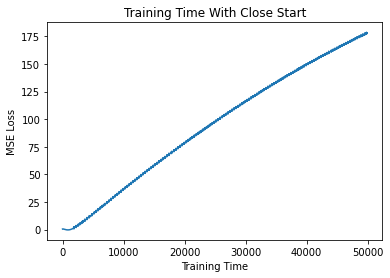

In [13]:
plt.plot(weights[100:])
plt.xlabel("Training Time")
plt.ylabel("MSE Loss")
plt.title("Training Time With Close Start")
plt.show()

# Float32 v. Float64

In [ ]:
df = pd.read_parquet("../data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X32 = data[:, :-1]
Y32 = data[:, -1]

import sklearn.linear_model
res, mod = train_with_CV(X32, Y32, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=False)
print(res)

data = df.to_numpy(dtype=np.float64)

X64 = data[:, :-1]
Y64 = data[:, -1]

res, mod = train_with_CV(X64, Y64, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=False)
print(res)

In [ ]:
plt.hist(mod.coef_)
plt.title("Histogram of weights for linear regression")
plt.show()

## Try normalization after the fact

In [ ]:
# With norm
data = df.to_numpy(dtype=np.float32)

X32 = data[:, :-1]
Y32 = data[:, -1]

res, mod = train_with_CV(X32, Y32, sklearn.linear_model.LinearRegression, sklearn.metrics.mean_absolute_error, norm=True)
print(res)

data = df.to_numpy(dtype=np.float64)

X64 = data[:, :-1]
Y64 = data[:, -1]

res, mod = train_with_CV(X64, Y64, sklearn.linear_model.LinearRegression, sklearn.metrics.mean_absolute_error, norm=True)
print(res)

In [ ]:
data = df.to_numpy(dtype=np.float64)

X64 = data[:, :-1]
Y64 = data[:, -1]

metrics = []
kf = KFold(n_splits=5)
for train, test in kf.split(X64):
  x_train, y_train = X64[train], Y64[train]
  x_test, Y_test = X64[test], Y64[test]
  X_train, X_test, _ = normalize(x_train, x_test, y_train)

  X_train_32 = np.array(X_train, dtype=np.float32)
  Y_train_32 = np.array(y_train, dtype=np.float32)
  X_test_32 = np.array(X_test, dtype=np.float32)
  Y_test_32 = np.array(Y_test, dtype=np.float32)

  reg = sklearn.linear_model.LinearRegression()
  reg.fit(X_train_32, Y_train_32)

  reg1 = sklearn.linear_model.LinearRegression()
  reg1.fit(X_train, y_train)

  # Y_pred = reg.predict(X_test_32) * np.std(y_train) + np.mean(y_train)
  Y_pred = reg.predict(X_test_32)
  m = calc_percent_diff(Y_test_32, Y_pred)
  metrics.append(m)

plot_pred_v_actual(Y_pred, Y_test_32)

print(np.mean(metrics))

In [ ]:
np.mean(np.abs(reg.coef_ - reg1.coef_))

## Linear Regression Feature Importance

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

df = pd.read_parquet("../data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X = data[:, :-1]
y = data[:, -1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

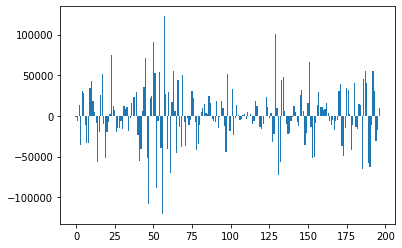

In [ ]:
model = LinearRegression()

n_features = len(X[0])
X_standard = normalize_one(X)

model.fit(X_standard, y)
avg_importance = model.coef_

# plot feature importance
pyplot.bar([x for x in range(len(avg_importance))], avg_importance)
pyplot.show()

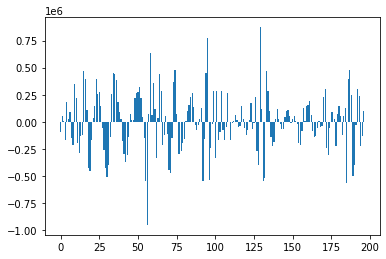

0.9987234173475737

In [ ]:
model = LinearRegression()

n_features = len(X[0])

model.fit(X, y)
avg_importance = model.coef_

# plot feature importance
pyplot.bar([x for x in range(len(avg_importance))], avg_importance)
pyplot.show()
model.score(X, y)

In [ ]:
# get top lasers
feature_scores = {}
positive_features = []
for feature, score in enumerate(avg_importance):
  feature_scores[score] = feature
  if score > 0:
    positive_features.append(feature)
	# print('Feature: %0d, Score: %.5f' % (feature, score))

top_importance = np.sort(avg_importance)
top_importance = top_importance[::-1]

top_k = 20
top_lasers = []
for i in range(top_k):
  score = top_importance[i]
  feature = feature_scores[score]
  top_lasers.append(feature)
  print(f"Feature: {feature}, Score: {score}")


Feature: 129, Score: 872261.3125
Feature: 95, Score: 769367.75
Feature: 58, Score: 631415.125
Feature: 74, Score: 476432.03125
Feature: 187, Score: 474340.625
Feature: 133, Score: 468020.78125
Feature: 15, Score: 464660.34375
Feature: 94, Score: 449657.90625
Feature: 34, Score: 446681.1875
Feature: 64, Score: 441862.0625
Feature: 35, Score: 441335.9375
Feature: 23, Score: 396782.46875
Feature: 16, Score: 394556.90625
Feature: 186, Score: 393357.25
Feature: 36, Score: 386519.46875
Feature: 73, Score: 362947.75
Feature: 60, Score: 360855.71875
Feature: 9, Score: 349183.34375
Feature: 51, Score: 322380.6875
Feature: 171, Score: 306009.625


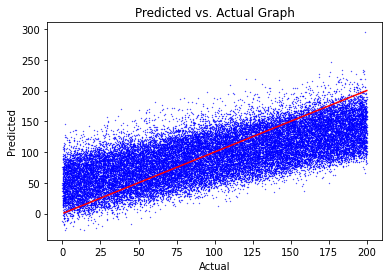

37.77358114719391


In [ ]:
import sklearn.linear_model

# top lasers 
X_top = X[:, top_lasers]
res, mod = train_with_CV(X_top, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=False)
print(res)

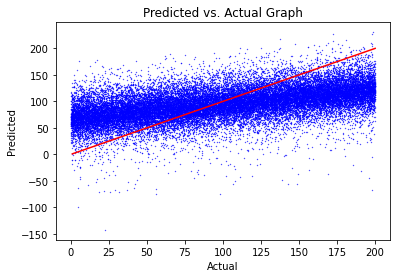

56.9838809967041


In [ ]:
import random

random_lasers = [random.randint(0, 196) for i in range(top_k)]
X_rand = X[:, random_lasers]
res, mod = train_with_CV(X_rand, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=False)
print(res)

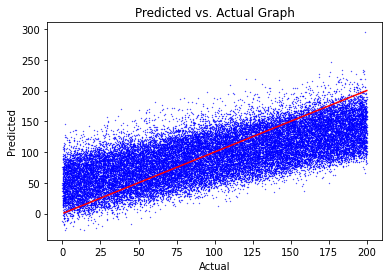

37.77358114719391


In [ ]:
import sklearn.linear_model

# top 15 lasers 
# top_lasers = [129, 95, 58, 74, 187, 133, 15, 94, 34, 64, 35, 23, 16, 186, 36]
X_15 = X[:, top_lasers]
res, mod = train_with_CV(X_15, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=False)
print(res)

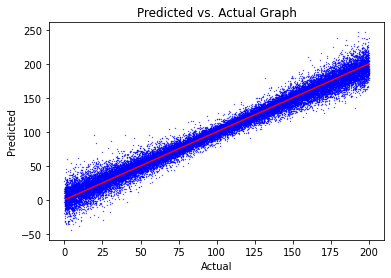

37.84514665603638


In [ ]:
import random

random_lasers = [random.randint(0, 196) for i in range(top_k)]
X_rand = X[:, random_lasers]
res, mod = train_with_CV(X_rand, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=True)
print(res)

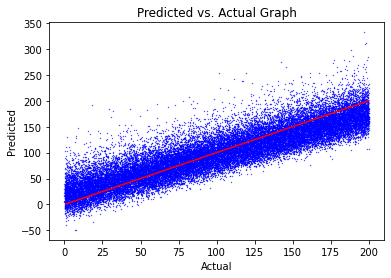

44.790053367614746


In [ ]:
import sklearn.linear_model

# top 15 lasers 
top_lasers = [129, 95, 58, 74, 187, 133, 15, 94, 34, 64, 35, 23, 16, 186, 36]
X_15 = X[:, top_lasers]
res, mod = train_with_CV(X_15, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=True)
print(res)

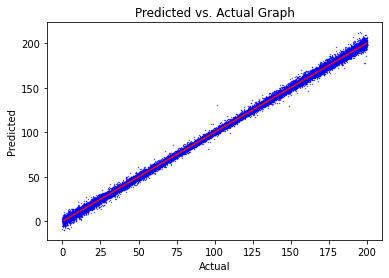

30.14993578195572


In [ ]:
import sklearn.linear_model

# Using positive scoring features
X_pos = X[:, positive_features]
res, mod = train_with_CV(X_pos, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=True)
print(res)


In [ ]:
print(len(positive_features))

105


In [ ]:
abs_25 = []
for feature, score in enumerate(avg_importance):
  if abs(score) > 0.25 * 1000000:
    abs_25.append(feature)

# Using positive scoring features
X_25 = X[:, abs_25]
res, mod = train_with_CV(X_25, y, sklearn.linear_model.LinearRegression, calc_percent_diff, norm=True)
print(res)

print(len(abs_25))

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

df = pd.read_parquet("../data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X = data[:, :-1]
Y = data[:, -1]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state=42)
X_train, X_test, _ = normalize(X_train, X_test, y_train)


# Create the classifier: logreg
logreg = LogisticRegression(max_iter=2000)

y_train = np.array(y_train >= 80, dtype=int)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

y_test = np.array(y_test >= 80, dtype=int)

# Compute and print the confusion matrix and classification report
cfn_matrix = confusion_matrix(y_test, y_pred)
print(cfn_matrix)
print(classification_report(y_test, y_pred))


[[23623  2099]
 [ 1121 37157]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     25722
           1       0.95      0.97      0.96     38278

    accuracy                           0.95     64000
   macro avg       0.95      0.94      0.95     64000
weighted avg       0.95      0.95      0.95     64000



Text(0.5, 257.44, 'Predicted label')

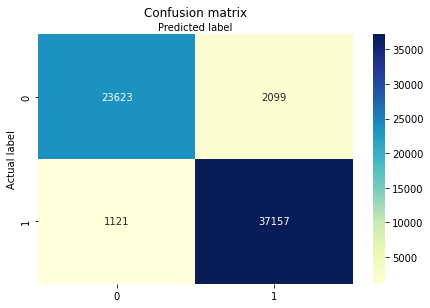

In [ ]:
# import required modules
import seaborn as sns
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cfn_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


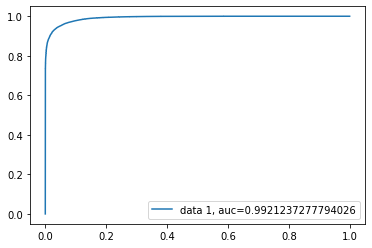

In [ ]:
from sklearn import metrics

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()